In [1]:
from utils.utils import VarData

filename = "DATA/tas_Amon_GFDL-SPEAR-MED_historical_r1i1p1f1_gr3_192101-201412.nc"
variable = "tas"

Tas = VarData(filename, variable)
Tas.load_data()
Tas.interpolate_data(xres=4, yres=4)
Tas.add_spatial_features()
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, y_train, y_test = Tas.split_data()

# Reshape X_train and X_test for a 2D conv (i.e (N_samples, lags*5, lat, lon))
X_train_scaled = Tas.reshape_for_model(X_train_scaled, model_type="2dcnn")
X_test_scaled = Tas.reshape_for_model(X_test_scaled, model_type="2dcnn")

# Reshape y_train and y_test to be consistent (i.e (N_samples, 1, lat, lon))
y_train_scaled = y_train_scaled[:, None, :, :]
y_test_scaled  = y_test_scaled[:, None, :, :]

tas - INFO - Opening the file for DATA/tas_Amon_GFDL-SPEAR-MED_historical_r1i1p1f1_gr3_192101-201412.nc
tas - INFO - Reading data for variable: tas
tas - INFO - Size of the data: (1128, 360, 576)
tas - INFO - Interpolating data to resolution: 4x4
tas - INFO - Size of the data: (1128, 90, 144)
tas - INFO - Getting spatial features for the dataset
tas - INFO - Combine variable data and spatial encodings
tas - INFO - Size of the full data set (1128, 90, 144, 5)
tas - INFO - Raw train shape (before scaling & lagging): (902, 90, 144, 5)
tas - INFO - Raw test shape  (before scaling & lagging): (226, 90, 144, 5)
tas - INFO - Using GridScaler for per-grid standardization...
tas - INFO - Creating lagged dataset using 3 lags...
tas - INFO - Lagged X shape: (899, 3, 90, 144, 5)
tas - INFO - Lagged y shape: (899, 90, 144)
tas - INFO - Creating lagged dataset using 3 lags...
tas - INFO - Lagged X shape: (223, 3, 90, 144, 5)
tas - INFO - Lagged y shape: (223, 90, 144)
tas - INFO - Final X_train shap

In [2]:
from architectures.cnn_baseline import CNN2D_Baseline
Baseline = CNN2D_Baseline(in_channels=X_train_scaled.shape[1])
train_loader, test_loader = Baseline.create_data_loaders(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)
Baseline.train_model(train_loader, test_loader, num_epochs=50)

Model Architecture:
Sequential(
  (0): Conv2d(15, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


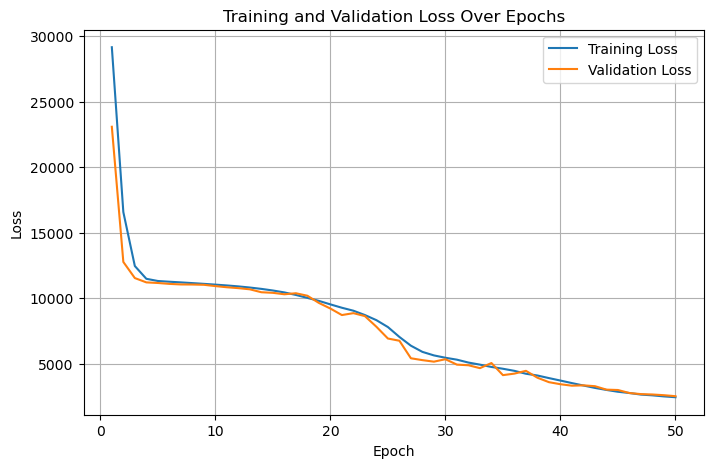

Global RMSE (K): 126.570163
Global Persistence RMSE (K): 277.225767


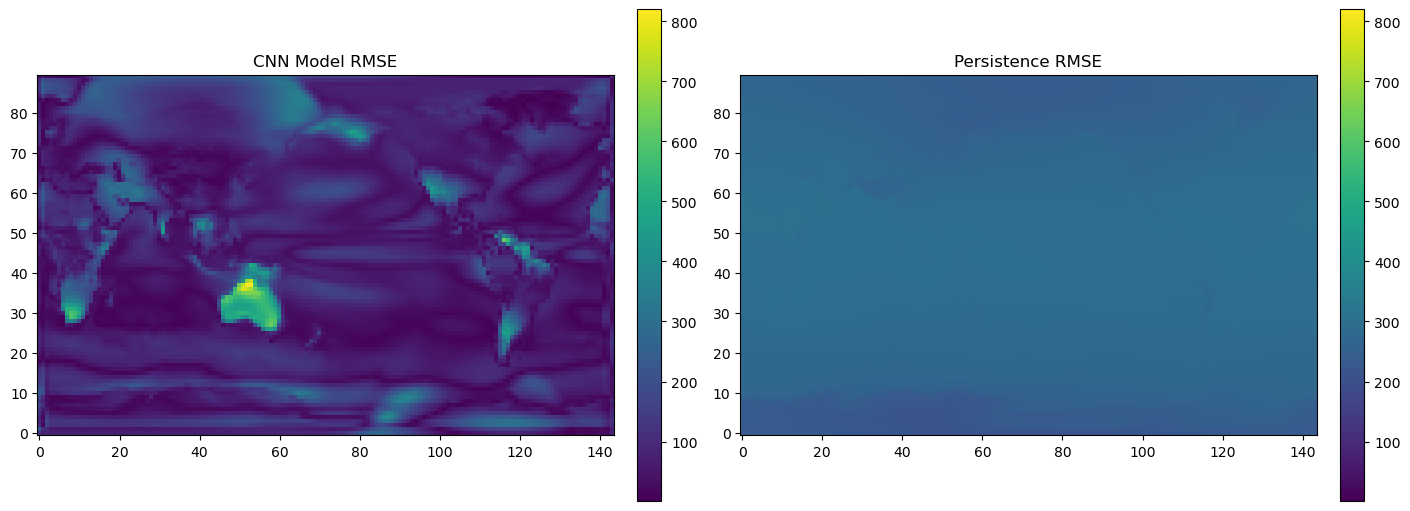

In [3]:
Baseline.plot_loss_over_epochs()
Baseline.get_rmse(Tas, X_test_scaled, y_test_scaled)

In [4]:
Baseline_batchnorm = CNN2D_Baseline(in_channels=X_train_scaled.shape[1], case=1, label="baseline_batchnorm")
Baseline_batchnorm.train_model(train_loader, test_loader, num_epochs=50)

Model Architecture:
Sequential(
  (0): Conv2d(15, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


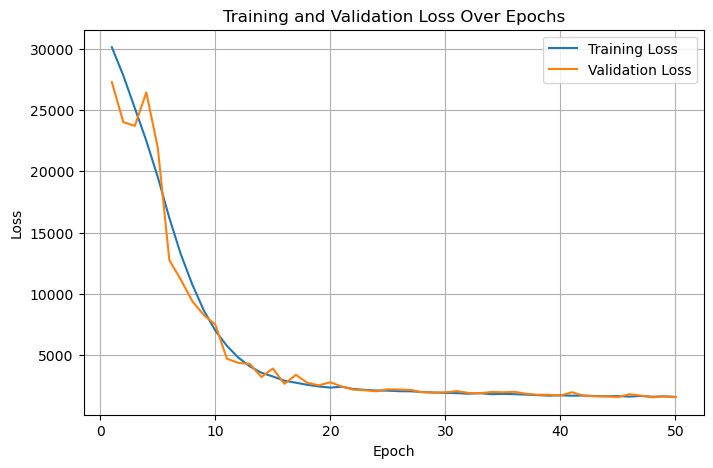

Global RMSE (K): 95.273342
Global Persistence RMSE (K): 277.225767


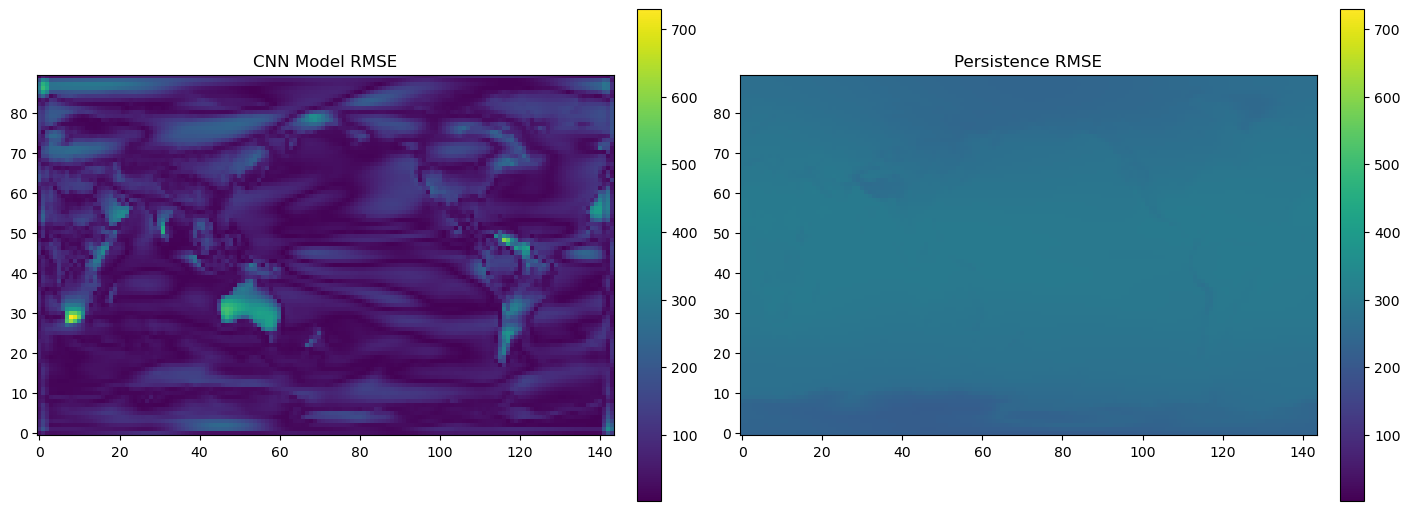

In [5]:
Baseline_batchnorm.plot_loss_over_epochs()
Baseline_batchnorm.get_rmse(Tas, X_test_scaled, y_test_scaled)

In [6]:
Baseline_batchnorm_sampling = CNN2D_Baseline(in_channels=X_train_scaled.shape[1], case=2, label="Baseline_batchnorm_sampling")
Baseline_batchnorm_sampling.train_model(train_loader, test_loader, num_epochs=50)

Model Architecture:
Sequential(
  (0): Conv2d(15, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2), output_padding=(2, 2))
  (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): ConvTran

RuntimeError: output padding must be smaller than either stride or dilation, but got output_padding_height: 2 output_padding_width: 2 stride_height: 2 stride_width: 2 dilation_height: 1 dilation_width: 1

In [ ]:
Baseline_batchnorm_sampling.plot_loss_over_epochs()
Baseline_batchnorm_sampling.get_rmse(Tas, X_test_scaled, y_test_scaled)